# IronKaggle

## You have a dataset containing information on shops’ sales per day (and several characteristics of them) - your goal is to predict the sales!

### Training data (640841 entries): we will share with you a training set of store sales per day, with bits of information of what happened in that day in that store.

### Real-Life Data (+70k entries): we will also share with you entries without the sales. This will be used (on the teachers side) to verify how good your model really is!

### Expected Deliver:
- “Real-life data set” with an extra column called “sales”, with your predictions (in .csv)
- An expected value of R2 of performance of your model
- A 5’ presentation on the choices you did and the road you took

In [100]:
# imports
import pandas as pd
import numpy as np

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Model Training 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Early stop to save time
from tensorflow.keras.callbacks import EarlyStopping

# Data Exploration

For this project I'll be using the sales.csv data set and so I'll begin by exploring the data and checking for any missing vaules.

In [33]:
data = pd.read_csv('sales.csv')

In [35]:
# Visualize first rows of the data
data.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [37]:
# Information about the data |set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


In [18]:
data['state_holiday'].unique()

array(['0', 'a', 'c', 'b'], dtype=object)

## Processing data into numerical values

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Process the 'date' column
# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Extract relevant features from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek                    # 0 = Monday, 6 = Sunday
data['is_weekend'] = (data['date'].dt.dayofweek >= 5).astype(int)  # 1 if weekend, 0 otherwise

# Drop the original 'date' column if no longer needed
data.drop(columns=['date'], inplace=True)

# Process the 'state_holiday' column
# Initialize one-hot encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Dropping first category to avoid multicollinearity

# Fit-transform 'state_holiday'
state_holiday_encoded = encoder.fit_transform(data[['state_holiday']])

# Convert the encoded result into a DataFrame
state_holiday_df = pd.DataFrame(
    state_holiday_encoded, 
    columns=encoder.get_feature_names_out(['state_holiday'])
)

# Add the new one-hot encoded columns to the main DataFrame
data = pd.concat([data, state_holiday_df], axis=1)

# Drop the original 'state_holiday' column
data.drop(columns=['state_holiday'], inplace=True)

# Check
print(data.head())

In [96]:
# Check
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           640840 non-null  int64  
 1   store_ID             640840 non-null  int64  
 2   day_of_week          640840 non-null  int32  
 3   nb_customers_on_day  640840 non-null  int64  
 4   open                 640840 non-null  int64  
 5   promotion            640840 non-null  int64  
 6   school_holiday       640840 non-null  int64  
 7   sales                640840 non-null  int64  
 8   year                 640840 non-null  int32  
 9   month                640840 non-null  int32  
 10  day                  640840 non-null  int32  
 11  is_weekend           640840 non-null  int32  
 12  state_holiday_a      640840 non-null  float64
 13  state_holiday_b      640840 non-null  float64
 14  state_holiday_c      640840 non-null  float64
dtypes: float64(3), in

# Training the Model

- Separate Features and target variable
- Split data into test and training
- Scale the data

In [46]:
# Separate Features and Target Variable
X = data.drop(columns=['sales'])  # Replace 'sales' with the name of your target column
y = data['sales']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose and Apply a Scaler
scaler = StandardScaler()  # Use MinMaxScaler() if preferred
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check Scaled Data
print("Before scaling:", X_train.iloc[0])
print("After scaling:", X_train_scaled[0])

Before scaling: Unnamed: 0             346971.0
store_ID                  275.0
day_of_week                 2.0
nb_customers_on_day       680.0
open                        1.0
promotion                   1.0
school_holiday              0.0
year                     2015.0
month                       7.0
day                        29.0
is_weekend                  0.0
state_holiday_a             0.0
state_holiday_b             0.0
state_holiday_c             0.0
Name: 360184, dtype: float64
After scaling: [-0.04313508 -0.87880299 -0.50115648  0.10017559  0.45221223  1.2725205
 -0.46547853  1.50338982  0.34711046  1.51226025 -0.63108744 -0.14262637
 -0.08094245 -0.06445413]


In [52]:
# Check the shape of training and test data
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

Training Features Shape: (512672, 14)
Test Features Shape: (128168, 14)
Training Labels Shape: (512672,)
Test Labels Shape: (128168,)


## Model

In [241]:
# Create a Sequential model
# Create a Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), 
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization                                         
    tf.keras.layers.Dense(32, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)                                                   # Output 
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print the model summary to see its architecture
model.summary()

C:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [243]:
# Early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the train data
history = model.fit(
    X_train_scaled, y_train, 
    validation_data=(X_test_scaled, y_test), 
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping]
) 

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate R² and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Epoch 1/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12107918.0000 - mean_absolute_error: 2137.0852 - val_loss: 2076528.0000 - val_mean_absolute_error: 945.9575
Epoch 2/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1976060.8750 - mean_absolute_error: 932.7006 - val_loss: 1882440.3750 - val_mean_absolute_error: 902.0849
Epoch 3/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1854778.2500 - mean_absolute_error: 901.6379 - val_loss: 1854969.3750 - val_mean_absolute_error: 895.1565
Epoch 4/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1838140.8750 - mean_absolute_error: 897.6335 - val_loss: 1838234.1250 - val_mean_absolute_error: 893.0172
Epoch 5/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1822035.0000 - mean_absolute_error: 895.3271 - val_loss: 1826666.1250 - val_mean_absolute_error: 892.0363
Epoch 6/20
4006/4006 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1800213.6250 - mean_absolute_error: 891.3325 - val_loss: 1817076.7500 - val_mean_absolute_error:

Results From last Test:
- Test Mean Absolute Error (MAE): 879.6699
- Test Loss (MSE): 1763880.6250
- R-squared: 0.8807
- Mean Squared Error (MSE): 1763865.3579

### Graph to visualize how the training and test data are performing

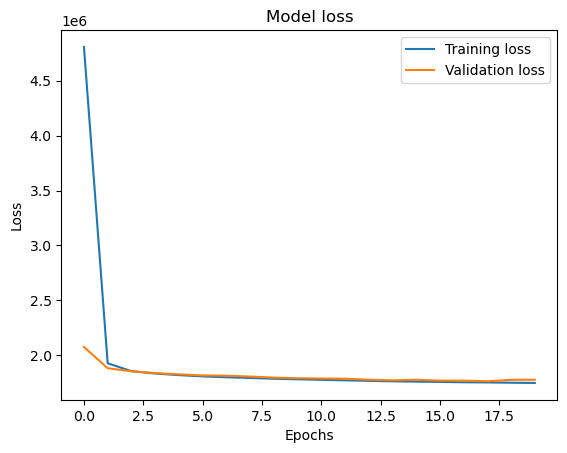

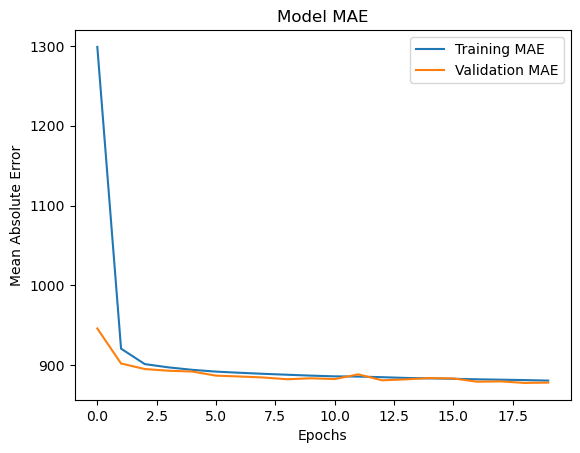

In [245]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend(['Training MAE', 'Validation MAE'])
plt.show()

# Save the model

In [251]:
# Save the model
model.save('ironkaggle.keras')